In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import warnings
import json
import datetime
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def get_clean_data(df_original):
    weekday_dict = {
        0:'Wd', 1:'Wd', 2:'Wd', 3:'Wd', 4:'Wd', 5:'F', 6:'F' 
    }
    
    df = df_original.copy(deep=True)
    df['date'] =  pd.to_datetime(df['datetime'].apply(lambda x: x[:10]), format='%Y-%m-%d')
    df['year'] = df['date'].dt.year
    df['time'] = pd.to_datetime(df['datetime'].apply(lambda x: x[:19])).dt.time
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['datetime'].apply(lambda x: x[11:13]).astype(int)
    df['minute'] = df['datetime'].apply(lambda x: x[14:16]).astype(int)
    df['weekday'] = df['date'].dt.dayofweek
    df['weekday_label'] = df['weekday']
    df.replace({'weekday_label':weekday_dict}, inplace=True)
    df['season'] = np.where(df['month'].isin(list(range(4,10))), 'summer', 'winter')
    df['date_hour'] = df.apply(lambda x: datetime.datetime.combine(x['date'], x['time']), axis=1)
    df.set_index('date_hour', inplace=True)
    df = df[df.index < '2017']
    clean_df = df[['date', 'year', 'month', 'season', 'day','weekday','weekday_label','time', 'hour', 'minute', 'value']]
    clean_df = clean_df[~clean_df.index.duplicated()]
    clean_df['hour_label'] = np.where(clean_df['hour'].isin(np.arange(9,23)), 'Peak', 'off_peak')
    #clean_df['value'] = np.log1p(clean_df['value'])
    clean_df_freq = clean_df.asfreq('H')
    
    return clean_df_freq

In [3]:
sec_res_up_raw = pd.read_csv('2014_2016_training_files/export_EnergíaUtilizadaDeRegulaciónSecundariaSubir_2017-02-26_18-37.csv', 
                        encoding='latin1', delimiter=';')
sec_res_up = get_clean_data(sec_res_up_raw)

In [4]:
#Non-use is defined if the secondary up reserve is lower than 1MW (minimum offer)
print('Non-use: %d\nTotal number of hours: %d\nProb of failure (non-use): %.6f\nProb of sucess: %.6f '%(
        len(sec_res_up[sec_res_up['value'] < 1]), len(sec_res_up),
        len(sec_res_up[sec_res_up['value'] < 1])/len(sec_res_up), len(sec_res_up[sec_res_up['value'] >= 1])/len(sec_res_up) ))

Non-use: 2766
Total number of hours: 26304
Prob of failure (non-use): 0.105155
Prob of sucess: 0.894731 


The secondary reserve can be modelled through a Bernoulli trial; where the failure is the non-utilisation of secondary reserve with probability p, p=0.105155, regardless of the hour and day of week. Next analysis focuses on possible breakdown of the utilisation looking at hour and kind of day.

In [5]:
#Non-use df
no_use_res = sec_res_up[sec_res_up['value'] < 1]

In [6]:
#High variability across hours
no_use_res['hour'].value_counts().to_frame()

,hour
10.0,240
9.0,198
21.0,196
11.0,170
22.0,166
12.0,166
8.0,160
20.0,157
19.0,152
13.0,147


In [7]:
#Difference between peak and off-peak hours
no_use_res['hour_label'].value_counts().to_frame()

,hour_label
Peak,2099
off_peak,667


In [8]:
#There is slight difference in day of the week
no_use_res['weekday'].value_counts().to_frame()

,weekday
4.0,456
2.0,439
1.0,420
3.0,404
0.0,371
5.0,366
6.0,310


In [9]:
#There are more Wd than F
no_use_res['weekday_label'].value_counts().to_frame()

,weekday_label
Wd,2090
F,676


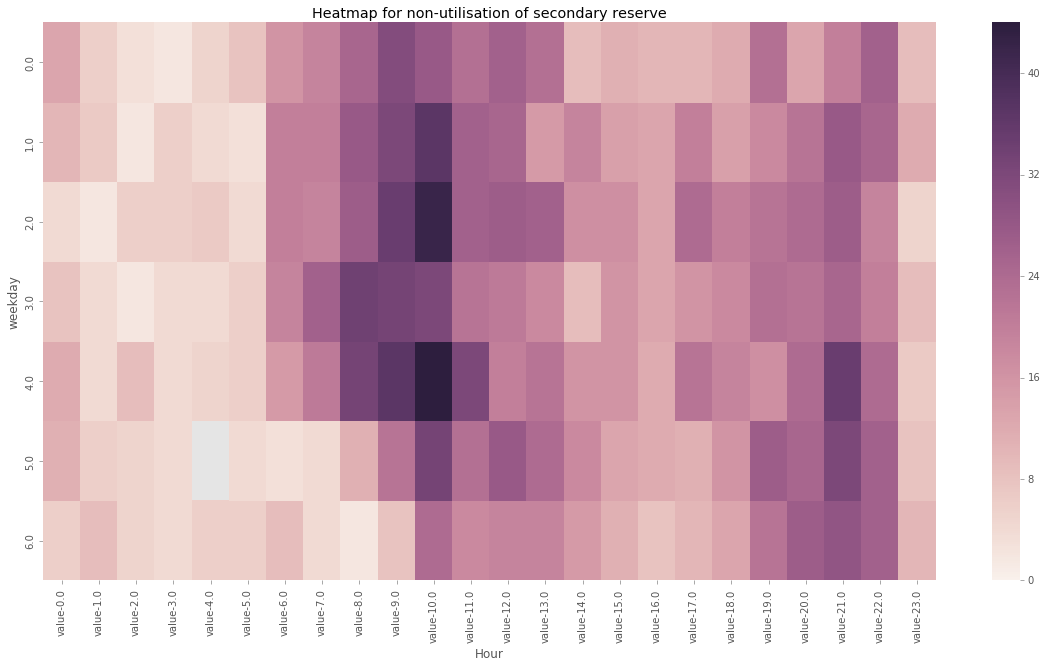

In [10]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.heatmap(no_use_res.groupby(['weekday', 'hour'])[['value']].count().unstack(-1), ax=ax,
            vmin=0, vmax=no_use_res.groupby(['weekday', 'hour'])['value'].count().max());
ax.set_xlabel('Hour')
ax.set_title('Heatmap for non-utilisation of secondary reserve');

In [11]:
#No difference between season
no_use_res['season'].value_counts()

summer    1545
winter    1221
Name: season, dtype: int64

In [12]:
#probability of success hourly
number_of_hours = sec_res_up.groupby('hour')['value'].count()
success_hour = sec_res_up[sec_res_up['value'] < 1].groupby('hour')['value'].count()
hourly_prob_bernoulli_trial = 1 - (success_hour / number_of_hours).to_frame()

These probabilities have been computed as $\frac{s}{T}$, where $s$ represents the number of observed successes and $T$ the number of samples, so they involve the best estimation for Bernoulli trial probability of success $p$, as $\frac{s}{T}$ maximises the likelihhod function for Bernoulli trial.

In [13]:
#Example of bernoulli trials for montecarlo simulation
bernoulli_prob_mc = np.empty((24,10000))
for index, prob in zip(range(24), hourly_prob_bernoulli_trial['value'].values.tolist()):
    bernoulli_prob_mc[index] = np.random.binomial(1, prob, size=10000)

In [14]:
#Export hourly probabilities of bernoulli trials
bernoulli_prob_dict = {
    'hour':hourly_prob_bernoulli_trial.index.tolist(),
    'prob':hourly_prob_bernoulli_trial['value'].values.tolist()
}

with open('bernoulli_prob.json', 'w') as f:
     json.dump(bernoulli_prob_dict, f)